# Objectives of this notebook and discussion

This notebook aims to dig deeper into the data. By analysing the starting XI and the results of season 1, we measure the impact of players on game outcomes. To achieve this, we compute various statistics for the season based on whether a player was in the starting line-up or not. These measures allow us to evaluate each player's influence on game results.

In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import statsmodels.api as sm
from scipy.stats import poisson
from scipy import stats
from sklearn.preprocessing import StandardScaler
import numpy as np, scipy.stats as st
import json
from project_code.utils import *

In [ ]:
## Get the current working directory
current_directory = os.getcwd()
## Use a global variable for the path to the data
FILES_PATH = f"{current_directory}/data/"

## Dictionnary to decode the position on the field
POSITION_ENCODING = {1 : "Goalkeeper", 2 : "Defender", 3 : "Midfielder", 4 : "Forward"}

## Use a global variable for the path to save plots
FILES_PATH_RESULTS = f"{current_directory}/plots_probabilities_season2/"

In [3]:
fixtures_data = pd.read_csv(f"{FILES_PATH}fixtures.csv", delimiter=",")
odds_data = pd.read_csv(f"{FILES_PATH}odds.csv", delimiter=",")
players_data = pd.read_csv(f"{FILES_PATH}players.csv", delimiter=",")
results_data = pd.read_csv(f"{FILES_PATH}results.csv", delimiter=",")
startingXI_data = pd.read_csv(f"{FILES_PATH}startingXI.csv", delimiter=",")
teams_data = pd.read_csv(f"{FILES_PATH}teams.csv", delimiter=",")
goalkeeper_games = pd.read_parquet(f"{FILES_PATH}goalkeeper_games.pq")
goalkeeper_teams = pd.read_parquet(f"{FILES_PATH}goalkeeper_teams.pq")

We will only focus on the data from season 1

In [4]:
results_data_season1 = results_data.copy()
results_data_season1 = results_data_season1[results_data_season1["SeasonID"]==1]

## Data preprocessing
We use the same preprocessing method as used to generate the goalkeeper ratings. The class GoalkeeperPreprocessing is imported from the utils.py file, however, the class is commented in the cell below if the import doesn't work. Please uncomment and run it if needed.

As an output, we generate a dataset with a unique combination of game and player per row.

In [5]:
# class GoalkeeperPreprocessing:
#     def __init__(self, homonymous_player_names):
#         self.homonymous_player_names = homonymous_player_names
        
#     def create_player_ID(self, df : pd.DataFrame) -> pd.DataFrame:
#         """
#         Create a unique player ID. 
#         """
#         df["PlayerID"] = np.arange(1, len(df)+1)
#         return df
    
#     def link_players_to_teamID(self, players_data : pd.DataFrame, player_names : list)->str:
#         """
#         Link the team ID to the list of players in the dataset containing the starting XI of every game. 
#         It uses the players' name except for the ones which are not unique.
#         """
#         for _name in player_names:
#             if _name not in self.homonymous_player_names:
#                 return players_data[players_data["PlayerName"]==_name]["TeamID"].values[0]
#             else: 
#                 continue

#     def explode_startingXI_dataset(self, df : pd.DataFrame, players_data : pd.DataFrame) -> pd.DataFrame:
#         """
#         Return a StartingXI dataset with one unique player per row per game.
#         """
#         df = df.explode("StartingXI").rename(columns = {"StartingXI" : "PlayerName"})
#         df = df.merge(players_data, on = ["PlayerName", "TeamID"], how = "left")
#         df["MatchPlayed"] = 1 ## This variable will be useful later on for any calculations (e.g.: to count the number of games played)
#         return df
    
#     def run_goalkeeper_preprocessing(self, results_data : pd.DataFrame, startingXI_data : pd.DataFrame, players_data : pd.DataFrame) -> pd.DataFrame:
#         """
#         Run the preprocessing pipeline for the goalkeeper ratings generation. 
#         """
#         ## Creation of a unique player ID
#         players_data = self.create_player_ID(players_data)

#         ## Add team ID to the dataset using players' name
#         startingXI_data_copy = startingXI_data.copy()
#         startingXI_data_copy["StartingXI"] = startingXI_data_copy["StartingXI"].map(lambda x: x.split(","))
#         startingXI_data_copy["TeamID"] = startingXI_data_copy["StartingXI"].map(lambda x: self.link_players_to_teamID(players_data, x))

#         ## Explode the dataframe to get one player per row, per game, per team
#         startingXI_data_exploded = self.explode_startingXI_dataset(startingXI_data_copy, players_data)

#         ## Merge the season results with the players dataset
#         df_merged = startingXI_data_exploded.merge(results_data, on = ["MatchID"], how = "right")
#         results_with_players = df_merged.copy()
#         return results_with_players
    
#     def create_new_variables(self, df : pd.DataFrame) -> pd.DataFrame:
#         """
#         Creation of new variables which contain the number of goals scored by a team for a game
#         with no distinction of home/away.
#         """
#         df["TeamScore"] = df.apply(lambda x : x.HomeScore if x.TeamID == x.HomeTeamID else x.AwayScore, axis=1)
#         df["OpponentScore"] = df.apply(lambda x : x.AwayScore if x.TeamID == x.HomeTeamID else x.HomeScore, axis=1)
#         df = df.drop(columns = ["HomeScore", "AwayScore"])


#         df["TeamShots"] = df.apply(lambda x : x.HomeShots if x.TeamID == x.HomeTeamID else x.AwayShots, axis=1)
#         df["OpponentShots"] = df.apply(lambda x : x.AwayShots if x.TeamID == x.HomeTeamID else x.HomeShots, axis=1)
#         df = df.drop(columns = ["HomeShots", "AwayShots"])
#         return df


Generation of the list of players with the same name

In [6]:
## It is important to make the distinction between these players who share their name with at least another player.
## The list of identical name will be used as a global variable.
homonymous_player_names = players_data[players_data["PlayerName"].duplicated()]["PlayerName"].values

### Generation of the players/games dataset
Return the starting XI of every game with the outcomes of the game 

In [7]:
gk_preprocessing = GoalkeeperPreprocessing(homonymous_player_names)
results_with_players = gk_preprocessing.run_goalkeeper_preprocessing(results_data_season1, startingXI_data, players_data)
results_with_players = gk_preprocessing.create_new_variables(results_with_players)
results_with_players.head()

,MatchID,PlayerName,TeamID,PositionID,PlayerID,MatchPlayed,SeasonID,Gameweek,HomeTeamID,AwayTeamID,TeamScore,OpponentScore,TeamShots,OpponentShots
0,1,Stephen Sallee,7,1,628,1,1,1,7,1,1,1,17,12
1,1,Porter Harris,7,2,635,1,1,1,7,1,1,1,17,12
2,1,David Larson,7,2,636,1,1,1,7,1,1,1,17,12
3,1,Julius Skinner,7,2,631,1,1,1,7,1,1,1,17,12
4,1,Gerald Nelson,7,2,634,1,1,1,7,1,1,1,17,12


Add the number of points won by the team

In [8]:
def results_encoding(team_score, opponent_score):
    if team_score>opponent_score:
        return 3
    elif team_score == opponent_score:
        return 1
    else:
        return 0

## Add the number of points won by the team    
results_with_players["PointsScored"] = results_with_players.apply(lambda x : results_encoding(x.TeamScore, x.OpponentScore), axis = 1)
results_with_players["TeamWin"] = results_with_players["PointsScored"].map(lambda x : 1 if x == 3 else 0)
results_with_players["TeamLose"] = results_with_players["PointsScored"].map(lambda x : 1 if x == 0 else 0)
results_with_players["TeamDraw"] = results_with_players["PointsScored"].map(lambda x : 1 if x == 1 else 0)

## Add a constant variable to count the number of games played by a player later on
results_with_players["GamePlayed"] = 1

### Statistics generation per team and player
We begin by aggregating the results for each team across the season. By summing the variables listed below, we enable the calculation of season averages to better analyse team performance in season 1.

In [9]:
## Features of interest
cols_feature = [
"TeamScore",  
"OpponentScore", 
"TeamShots", 
"OpponentShots", 
"PointsScored", 
"TeamWin",
"TeamLose", 
"TeamDraw", 
# "GoalkeeperStrength",
"GamePlayed"
]

In [10]:
## Remove duplicates and useless columns as we reduce granularity from players to teams
results_teams = results_with_players[["MatchID", "TeamID", "TeamScore", "OpponentScore", "TeamShots", "OpponentShots", "PointsScored", "TeamWin", "TeamLose", "TeamDraw", "GamePlayed"]]
results_teams = results_teams.drop_duplicates()

## Group by team and sum the outcomes of every game over season 1
# results_teams["GoalkeeperStrength"] = 0
results_teams = results_teams.groupby(["TeamID"]).agg(
    {col: "sum" for col in cols_feature}
).reset_index()

## Add the goalkeeper strength
# results_teams["GoalkeeperStrength"] = results_teams["OpponentScore"]/results_teams["OpponentShots"]

## Add a prefix to identify team statistics
results_teams.columns = ["Team_"+str(x) for x in results_teams.columns]
results_teams.head()

,Team_TeamID,Team_TeamScore,Team_OpponentScore,Team_TeamShots,Team_OpponentShots,Team_PointsScored,Team_TeamWin,Team_TeamLose,Team_TeamDraw,Team_GamePlayed
0,1,80,60,771,654,77,21,19,14,54
1,2,43,130,530,987,32,7,36,11,54
2,3,68,106,600,877,56,13,24,17,54
3,4,136,41,943,501,117,35,7,12,54
4,5,130,58,1021,518,106,31,10,13,54


We continue by aggregating the results for each player across the season. By summing the variables of interest, we enable the calculation of season averages to better analyse player performance in season 1.

In [11]:
## Aggregate by player and sum the relevant variables over the season
agg_rules = {col: "sum" for col in cols_feature}
agg_rules["TeamID"] = lambda x : list(set(list(x)))[0] ## Keep the unique Team ID
agg_rules["PositionID"] = lambda x : list(set(list(x)))[0] ## Keep the unique Player ID

players_data_original = results_with_players.copy()
# players_data_original["GoalkeeperStrength"] = 0
players_features = players_data_original\
    .groupby("PlayerID").agg(
        agg_rules
    ).reset_index()

## Add the goalkeeper strength
# players_features["GoalkeeperStrength"] = players_features["OpponentScore"]/players_features["OpponentShots"]

## Add a prefix to identify player statistics
players_features.columns = ["Player_"+str(x) for x in players_features.columns]


Merger of the player and team statistics so we can then analyse the impact of a specific player on his team

In [12]:
players_teams_data = players_features.merge(results_teams, left_on = ["Player_TeamID"], right_on = ["Team_TeamID"], how = "left")

### Player influence calculation
We begin by isolating the player's impact on their team's performance:

- Subtract the number of goals the player scored during the season from the team's total goals scored for the season.
- Similarly, subtract the goals conceded while the player was on the pitch from the team's total goals conceded.
- Apply the same approach for the number of shots taken and conceded.

The team's data without the player's contribution have "Difference" as a prefix.

In [13]:
for col_name in cols_feature:
    players_teams_data["Difference_"+str(col_name)] = players_teams_data["Team_"+str(col_name)] - players_teams_data["Player_"+str(col_name)]

We add an additional variable: the goalkeeper strength.

As previously mentioned:
$$\frac{\text{Number of goals conceded}}{{\text{Number of shots conceded}}}$$

**This value will be computed for every player whatever their position but it only makes sense to use it for goalkeepers only.**

In [14]:
players_teams_data["Player_GoalkeeperStrength"] = players_teams_data["Player_OpponentScore"]/players_teams_data["Player_OpponentShots"]
players_teams_data["Team_GoalkeeperStrength"] = players_teams_data["Team_OpponentScore"]/players_teams_data["Team_OpponentShots"]
players_teams_data["Difference_GoalkeeperStrength"] = players_teams_data["Difference_OpponentScore"]/players_teams_data["Difference_OpponentShots"]

### Data normalisation
- The team's statistics, excluding the player's contributions, are divided by the number of games the player did not participate in.
- The player's individual statistics are divided by the number of games he played.

Example:

$$\frac{1}{\text{n}}\sum_{i}^{n}\text{Goals scored by the player}$$ 
$$\frac{1}{m}\sum_{j}^{m}\text{Goals scored by the team}$$

With:
- n: number of games where the player was in the starting XI
- m: number of games where the player was not in the starting XI

In [15]:
def data_normaliser(df : pd.DataFrame, norm_col : str, cols_feature : list = cols_feature) -> pd.DataFrame:
    """
    Normalise the data given the number of games played by a player or a team. 
    """
    cols_feature = [norm_col + str(x) for x in cols_feature]
    cols_feature_filtered = [x for x in cols_feature if x.startswith(norm_col)]
    normalising_feature = f"{norm_col}GamePlayed"
    gk_strength_feature = f"{norm_col}GoalkeeperStrength" 
    for col_name in cols_feature_filtered:
        ## We do not want to normalise the number of games played or the goalkeeper strength as it is already normalised
        if (col_name != normalising_feature) & (col_name != gk_strength_feature):
            df[col_name] = df[col_name] / df[normalising_feature]
    return df

players_teams_data = data_normaliser(players_teams_data, norm_col = "Difference_")
players_teams_data = data_normaliser(players_teams_data, norm_col = "Player_")

### Impact calculation
We then calculate the relative difference between the data with and without the player in the starting XI.

$$\frac{(\frac{1}{\text{n}}\sum_{i}^{n}\text{Goals scored by the player} - \frac{1}{m}\sum_{j}^{m}\text{Goals scored by the team})}{\frac{1}{m}\sum_{j}^{m}\text{Goals scored by the team}}$$

The variables generated have "Ratio" as a prefix.

In [16]:
players_teams_data

,Player_PlayerID,Player_TeamScore,Player_OpponentScore,Player_TeamShots,Player_OpponentShots,Player_PointsScored,Player_TeamWin,Player_TeamLose,Player_TeamDraw,Player_GamePlayed,...,Difference_TeamShots,Difference_OpponentShots,Difference_PointsScored,Difference_TeamWin,Difference_TeamLose,Difference_TeamDraw,Difference_GamePlayed,Player_GoalkeeperStrength,Team_GoalkeeperStrength,Difference_GoalkeeperStrength
0,1,0.933333,0.866667,14.066667,10.666667,1.200000,0.266667,0.333333,0.400000,15,...,14.358974,12.666667,1.512821,0.435897,0.358974,0.205128,39,0.081250,0.091743,0.095142
1,2,1.666667,1.238095,14.809524,13.380952,1.523810,0.428571,0.333333,0.238095,21,...,13.939394,11.303030,1.363636,0.363636,0.363636,0.272727,33,0.092527,0.091743,0.091153
2,3,1.722222,1.166667,13.833333,11.833333,1.500000,0.444444,0.388889,0.166667,18,...,14.500000,12.250000,1.388889,0.361111,0.333333,0.305556,36,0.098592,0.091743,0.088435
3,4,1.222222,1.037037,13.481481,12.037037,1.333333,0.333333,0.333333,0.333333,27,...,15.074074,12.185185,1.518519,0.444444,0.370370,0.185185,27,0.086154,0.091743,0.097264
4,5,1.483871,1.161290,13.193548,12.387097,1.290323,0.354839,0.419355,0.225806,31,...,15.739130,11.739130,1.608696,0.434783,0.260870,0.304348,23,0.093750,0.091743,0.088889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,696,1.095238,1.428571,12.714286,13.285714,1.238095,0.333333,0.428571,0.238095,21,...,9.515152,15.575758,0.787879,0.212121,0.636364,0.151515,33,0.107527,0.114754,0.118677
696,697,0.695652,1.608696,10.608696,15.304348,0.652174,0.173913,0.695652,0.130435,23,...,10.870968,14.225806,1.193548,0.322581,0.451613,0.225806,31,0.105114,0.114754,0.122449
697,698,1.133333,1.466667,10.466667,14.600000,1.400000,0.400000,0.400000,0.200000,15,...,10.871795,14.717949,0.794872,0.205128,0.615385,0.179487,39,0.100457,0.114754,0.120209
698,699,0.884615,1.961538,10.576923,13.653846,0.846154,0.230769,0.615385,0.153846,26,...,10.928571,15.642857,1.071429,0.285714,0.500000,0.214286,28,0.143662,0.114754,0.091324


In [17]:
for col_name in cols_feature:
    players_teams_data["Ratio_"+str(col_name)] = (players_teams_data["Player_"+str(col_name)] - players_teams_data["Difference_"+str(col_name)])/players_teams_data["Difference_"+str(col_name)]
players_teams_data["Ratio_GamePlayed"] = players_teams_data["Player_GamePlayed"] / players_teams_data["Team_GamePlayed"]

## Manually add the GoalkeeperStrength variables as they are a bit different from the other features
players_teams_data["Ratio_GoalkeeperStrength"] = (players_teams_data["Player_GoalkeeperStrength"] - players_teams_data["Difference_GoalkeeperStrength"])/players_teams_data["Difference_GoalkeeperStrength"]


### Team and player name are added to the dataset

In [18]:
players_teams_data

,Player_PlayerID,Player_TeamScore,Player_OpponentScore,Player_TeamShots,Player_OpponentShots,Player_PointsScored,Player_TeamWin,Player_TeamLose,Player_TeamDraw,Player_GamePlayed,...,Ratio_TeamScore,Ratio_OpponentScore,Ratio_TeamShots,Ratio_OpponentShots,Ratio_PointsScored,Ratio_TeamWin,Ratio_TeamLose,Ratio_TeamDraw,Ratio_GamePlayed,Ratio_GoalkeeperStrength
0,1,0.933333,0.866667,14.066667,10.666667,1.200000,0.266667,0.333333,0.400000,15,...,-0.448485,-0.280851,-0.020357,-0.157895,-0.206780,-0.388235,-0.071429,0.950000,0.277778,-0.146011
1,2,1.666667,1.238095,14.809524,13.380952,1.523810,0.428571,0.333333,0.238095,21,...,0.222222,0.201681,0.062422,0.183838,0.117460,0.178571,-0.083333,-0.126984,0.388889,0.015072
2,3,1.722222,1.166667,13.833333,11.833333,1.500000,0.444444,0.388889,0.166667,18,...,0.265306,0.076923,-0.045977,-0.034014,0.080000,0.230769,0.166667,-0.454545,0.333333,0.114843
3,4,1.222222,1.037037,13.481481,12.037037,1.333333,0.333333,0.333333,0.333333,27,...,-0.297872,-0.125000,-0.105651,-0.012158,-0.121951,-0.250000,-0.100000,0.800000,0.500000,-0.114231
4,5,1.483871,1.161290,13.193548,12.387097,1.290323,0.354839,0.419355,0.225806,31,...,0.003795,0.112903,-0.161736,0.055197,-0.197908,-0.183871,0.607527,-0.258065,0.574074,0.054687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,696,1.095238,1.428571,12.714286,13.285714,1.238095,0.333333,0.428571,0.238095,21,...,0.290816,-0.227166,0.336215,-0.147026,0.571429,0.571429,-0.326531,0.571429,0.388889,-0.093954
696,697,0.695652,1.608696,10.608696,15.304348,0.652174,0.173913,0.695652,0.130435,23,...,-0.383851,-0.076490,-0.024126,0.075816,-0.453584,-0.460870,0.540373,-0.422360,0.425926,-0.141572
697,698,1.133333,1.466667,10.466667,14.600000,1.400000,0.400000,0.400000,0.200000,15,...,0.300000,-0.171014,-0.037264,-0.008014,0.761290,0.950000,-0.350000,0.114286,0.277778,-0.164317
698,699,0.884615,1.961538,10.576923,13.653846,0.846154,0.230769,0.615385,0.153846,26,...,-0.115385,0.373077,-0.032177,-0.127151,-0.210256,-0.192308,0.230769,-0.282051,0.481481,0.573099


In [19]:
players_teams_data = players_data[["PlayerID", "PlayerName"]].merge(players_teams_data, left_on = "PlayerID", right_on = "Player_PlayerID", how = "right")
players_teams_data = teams_data.merge(players_teams_data, left_on = "TeamID", right_on = "Team_TeamID", how = "right")
players_teams_data = players_teams_data.drop(columns = [
    "Player_TeamID",
    "Team_TeamID",
    "Player_PlayerID"
])
players_teams_data = players_teams_data.rename(columns = {"Player_PositionID" : "PositionID"})
players_teams_data.head()

,TeamName,TeamID,PlayerID,PlayerName,Player_TeamScore,Player_OpponentScore,Player_TeamShots,Player_OpponentShots,Player_PointsScored,Player_TeamWin,...,Ratio_TeamScore,Ratio_OpponentScore,Ratio_TeamShots,Ratio_OpponentShots,Ratio_PointsScored,Ratio_TeamWin,Ratio_TeamLose,Ratio_TeamDraw,Ratio_GamePlayed,Ratio_GoalkeeperStrength
0,Arlington,1,1,Odell Williams,0.933333,0.866667,14.066667,10.666667,1.200000,0.266667,...,-0.448485,-0.280851,-0.020357,-0.157895,-0.206780,-0.388235,-0.071429,0.950000,0.277778,-0.146011
1,Arlington,1,2,Anthony Jennings,1.666667,1.238095,14.809524,13.380952,1.523810,0.428571,...,0.222222,0.201681,0.062422,0.183838,0.117460,0.178571,-0.083333,-0.126984,0.388889,0.015072
2,Arlington,1,3,Jeffrey Maxwell,1.722222,1.166667,13.833333,11.833333,1.500000,0.444444,...,0.265306,0.076923,-0.045977,-0.034014,0.080000,0.230769,0.166667,-0.454545,0.333333,0.114843
3,Arlington,1,4,Robert Compton,1.222222,1.037037,13.481481,12.037037,1.333333,0.333333,...,-0.297872,-0.125000,-0.105651,-0.012158,-0.121951,-0.250000,-0.100000,0.800000,0.500000,-0.114231
4,Arlington,1,5,Jason Kearns,1.483871,1.161290,13.193548,12.387097,1.290323,0.354839,...,0.003795,0.112903,-0.161736,0.055197,-0.197908,-0.183871,0.607527,-0.258065,0.574074,0.054687


## Statistics exploration

We calculate statistics on the number of games played by each player to evaluate the relevance of the data under the following assumptions:

- If a player has participated in fewer than 10% of the games, the data may not be representative or reliable for analysis.
- If a player has participated in more than 90% of the games, it may be difficult to assess their individual impact, as there is limited opportunity for comparison with other players in the same position who have rarely played.

In [27]:
min_percentage = players_teams_data["Ratio_GamePlayed"].min()
median_percentage = players_teams_data["Ratio_GamePlayed"].median()
max_percentage =  players_teams_data["Ratio_GamePlayed"].max()

print(f"Minimum percentage of games played is {min_percentage}")
print(f"Median of percentage of games played is {median_percentage}")
print(f"Maximum percentage of games played is {max_percentage}")

Minimum percentage of games played is 0.16666666666666666
Median of percentage of games played is 0.4444444444444444
Maximum percentage of games played is 0.6666666666666666


Our assumptions hold, no players need to be filtered out.

### 1. Most influencial players

We will use a simple metric: the relative difference in number of points with and without a player.
- We do find the player with the highest positive impact
- And the player with the highest negative impact

In [28]:
## Find the player with the highest negative impact
player_negative = players_teams_data.iloc[players_teams_data["Ratio_PointsScored"].idxmin()]

## Find the player with the highest positive impact
player_positive = players_teams_data.iloc[players_teams_data["Ratio_PointsScored"].idxmax()]

We extract their Team ID and their postion on the pitch. 
- They both play for the same team
- They are both goalkeepers

Therefore it is a perfect example of how a single player can influence the outcome of a game. It is probably more true with goalkeepers as their individual performance directly impact the number of goals.

In [29]:
def show_player_info(player_data : pd.Series) -> list[int, str, int]:
    """
    Return some information about a player. 
    """
    player_id = player_data["PlayerID"]
    position_player = player_data["PositionID"]
    name_player = player_data["PlayerName"]
    team_player = player_data["TeamName"]
    position_player_decoded = POSITION_ENCODING[position_player]
    ratio_points = player_data["Ratio_PointsScored"]
    return player_id, name_player, position_player, position_player_decoded, team_player, ratio_points

player_id_negative, name_player_negative, position_player_negative, position_player_negative_decoded, team_player_negative, ratio_points_negative = show_player_info(player_negative)
print(f"{name_player_negative} is the player with the highest negative influence. He is a {position_player_negative_decoded} playing for {team_player_negative}.")

player_id_positive, name_player_positive, position_player_positive, position_player_positive_decoded, team_player_positive, ratio_points_positive = show_player_info(player_positive)
print(f"{name_player_positive} is the player with the highest positive influence. He is a {position_player_positive_decoded} playing for {team_player_positive}.")


Charles Bates is the player with the highest negative influence. He is a Goalkeeper playing for New York C.
Charles Sanchez is the player with the highest positive influence. He is a Goalkeeper playing for New York C.


Here are the overall statistics regarding Bates' and Sanchez' season

In [30]:
extreme_players = players_teams_data[players_teams_data["PlayerID"].isin([player_id_negative, player_id_positive])]
extreme_players[[x for x in extreme_players.columns if x.startswith("Ratio_") or x in ["TeamName", "PlayerName"]]]

,TeamName,PlayerName,Ratio_TeamScore,Ratio_OpponentScore,Ratio_TeamShots,Ratio_OpponentShots,Ratio_PointsScored,Ratio_TeamWin,Ratio_TeamLose,Ratio_TeamDraw,Ratio_GamePlayed,Ratio_GoalkeeperStrength
300,New York C,Charles Sanchez,0.406427,-0.048593,-0.000839,-0.001523,2.369565,4.391304,-0.201288,0.347826,0.425926,-0.047142
301,New York C,Charles Bates,-0.253036,0.041637,-0.042908,0.105560,-0.842308,-1.000000,0.220844,-0.369231,0.240741,-0.057820


We see that when Charles Shanchez is playing, the team scores almost 237% more points than when he is not playing. 
On the contrary, when Charles Bates is in the goal, the team scores 84% less points than usual.

## 2. Do goalkeepers impact the game more than any other players?
As it was our assumption building the model, let's check how accurate it is.
We will estimate the influence of every position on the game outcome for every team.

In [31]:
rankin_season1 = results_data_season1.copy()
rankin_season1 = add_team_name(rankin_season1, teams_data)
rankin_season1["HomePoints"] = rankin_season1.apply(lambda x: add_points(x.HomeScore, x.AwayScore), axis=1)
rankin_season1["AwayPoints"] = rankin_season1.apply(lambda x: add_points(x.AwayScore, x.HomeScore), axis=1)
df_all_team = melt_results_dataset(rankin_season1)
rankin_season1 = generate_final_ranking(df_all_team)
rankin_season1

,TeamID,TeamName,TotalPoints,Ranking
0,15,Miami,138,1
1,8,Cincinnati,125,2
2,4,Baltimore,117,3
3,19,New York S,113,4
4,5,Boston,106,5
5,27,Seattle,105,6
6,6,Chicago B,105,7
7,21,Oakland,96,8
8,7,Chicago H,95,9
9,24,St. Louis,94,10


In [35]:
players_teams_data["PositionName"] = players_teams_data["PositionID"].map(POSITION_ENCODING)

In [85]:
team_points_var = players_teams_data.groupby(["PositionID", "PositionName"])["Ratio_PointsScored"].var().reset_index()

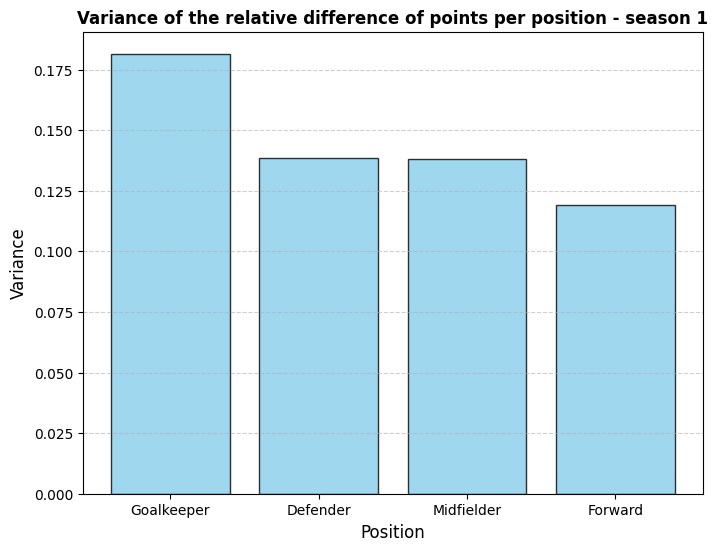

In [ ]:
# plt.bar(team_points_var.PositionName, team_points_var.Ratio_PointsScored)
# team_name = teams_data[teams_data["TeamID"]==i]["TeamName"].values[0]
# ranking_team = df_ranking_season2_proba[f"TeamID_{i}"]
# confidence_intervals_values = df_CI_length[f"TeamID_{i}"]
# ranking_team_plot = ranking_team[ranking_team!=0]
# confidence_intervals_values_plot = confidence_intervals_values[ranking_team_plot.index]

plt.figure(figsize = (8,6))
plt.bar(team_points_var.PositionName, team_points_var.Ratio_PointsScored,color='skyblue', edgecolor='black', alpha=0.8)
plt.title(f"Variance of the relative difference of points per position - season 1", fontsize=12, fontweight='bold')
# plt.xticks(ranking_team_plot.index)
plt.xlabel("Position", fontsize=12)
plt.ylabel("Variance", fontsize=12)
# plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig(f"{FILES_PATH_RESULTS}predictions_season2_{team_name}.png")
plt.close()
plt.show()

In [57]:
players_teams_data[(players_teams_data["TeamID"]==1) & (players_teams_data["PositionID"]==1)]

,TeamName,TeamID,PlayerID,PlayerName,Player_TeamScore,Player_OpponentScore,Player_TeamShots,Player_OpponentShots,Player_PointsScored,Player_TeamWin,...,Ratio_OpponentScore,Ratio_TeamShots,Ratio_OpponentShots,Ratio_PointsScored,Ratio_TeamWin,Ratio_TeamLose,Ratio_TeamDraw,Ratio_GamePlayed,Ratio_GoalkeeperStrength,PositionName
0,Arlington,1,1,Odell Williams,0.933333,0.866667,14.066667,10.666667,1.20000,0.266667,...,-0.280851,-0.020357,-0.157895,-0.20678,-0.388235,-0.071429,0.950000,0.277778,-0.146011,Goalkeeper
1,Arlington,1,2,Anthony Jennings,1.666667,1.238095,14.809524,13.380952,1.52381,0.428571,...,0.201681,0.062422,0.183838,0.11746,0.178571,-0.083333,-0.126984,0.388889,0.015072,Goalkeeper
2,Arlington,1,3,Jeffrey Maxwell,1.722222,1.166667,13.833333,11.833333,1.50000,0.444444,...,0.076923,-0.045977,-0.034014,0.08000,0.230769,0.166667,-0.454545,0.333333,0.114843,Goalkeeper


In [76]:
tt = players_teams_data.groupby(["TeamName", "TeamID", "PositionID", "PositionName"])["Ratio_PointsScored"].var().reset_index()

ll = players_teams_data.groupby(["TeamName", "TeamID", "PositionID", "PositionName"])["Ratio_GamePlayed"].var().reset_index()

In [70]:
top_five_ranks = rankin_season1[rankin_season1["Ranking"]<=5]["TeamID"]
bottom_five_ranks = rankin_season1[rankin_season1["Ranking"]>=24]["TeamID"]

In [81]:
tt[tt["TeamID"].isin(bottom_five_ranks)]

,TeamName,TeamID,PositionID,PositionName,Ratio_PointsScored
0,Anaheim,2,1,Goalkeeper,0.191737
1,Anaheim,2,2,Defender,0.437875
2,Anaheim,2,3,Midfielder,0.534477
3,Anaheim,2,4,Forward,0.152747
36,Denver,10,1,Goalkeeper,0.461461
37,Denver,10,2,Defender,0.175703
38,Denver,10,3,Midfielder,0.189943
39,Denver,10,4,Forward,0.167322
60,Milwaukee,16,1,Goalkeeper,0.306291
61,Milwaukee,16,2,Defender,0.356857
